In [1]:
import os
import sys
import re
import cv2
import ast
import random
import pandas as pd
import numpy as np

from PIL import Image
import albumentations as A
from collections import namedtuple
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path

import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold

import shutil

In [2]:
sys.path.insert(1, '../src')
from utils import set_seed, convert_bbox

my_seed = 2402
set_seed(my_seed)

In [3]:
base_dir = Path('../data')

In [4]:
def load_data_from_directory(directory_path):
    # Initialize lists to store the bounding box details
    image_names = []
    classes = []
    x_min_list = []
    y_min_list = []
    x_max_list = []
    y_max_list = []
    
    # Iterate over each CSV file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory_path, filename)
            data_df = pd.read_csv(file_path, header=None, names=['image_name', 'class', 'bboxes'])
            
            # Iterate over each row in the DataFrame
            for index, row in data_df.iterrows():
                image_name = row['image_name']
                class_id = row['class']
                bboxes = row['bboxes']
                
                # Handle case where there are no bounding boxes
                if pd.isna(bboxes) or bboxes.strip() == '':
                    image_names.append(image_name)
                    classes.append(class_id)
                    x_min_list.append(bboxes)
                    y_min_list.append(bboxes)
                    x_max_list.append(bboxes)
                    y_max_list.append(bboxes)
                    continue
                    
                # Split the bounding boxes and process each one
                for bbox in bboxes.split(';'):
                    x_min, y_min, width, height = map(float, bbox.split())
                    
                    # Maintain float values for bounding boxes
                    x_max = x_min + width
                    y_max = y_min + height
                    
                    # Append the details to the respective lists
                    image_names.append(image_name)
                    classes.append(class_id)
                    x_min_list.append(x_min)
                    y_min_list.append(y_min)
                    x_max_list.append(x_max)
                    y_max_list.append(y_max)
        
    # Create a new DataFrame with the structured data
    structured_df = pd.DataFrame({
        'image_name': image_names,
        'class': classes,
        'x_min': x_min_list,
        'y_min': y_min_list,
        'x_max': x_max_list,
        'y_max': y_max_list
    })
    
    print('DataFrame size: ', structured_df.shape)
    return structured_df

In [5]:
directory_path = base_dir/"labels"
data_df = load_data_from_directory(directory_path)
print(data_df.head())

DataFrame size:  (45354, 6)
       image_name  class  x_min  y_min   x_max  y_max
0   image_410.png      2  130.0   22.0   583.0  493.0
1  image_1143.png      3  517.0  366.0   679.0  462.0
2  image_1143.png      3  518.0    0.0   614.0  233.0
3  image_1143.png      3  943.0  423.0  1023.0  503.0
4  image_1143.png      3  720.0    1.0   820.0   82.0


In [62]:
data_df['image_name'].nunique()

1421

In [6]:
def get_image_path(image_name):
    return base_dir/f"images/{image_name}"

def read_img(image_name, path=False):
    if path:
        img_path=image_name
    else:
        img_path = get_image_path(image_name)
    img = cv2.imread(str(img_path))
    return img

def draw_rect(img, bboxes, color=(255, 0, 0)):
    img = img.copy()
    for bbox in bboxes:
        bbox = np.array(bbox).astype(int)
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img


def read_bboxes(df, image_name):
    return df.loc[df.image_name == image_name, 'x_min y_min x_max y_max'.split()].values

def plot_img(image_name, bbox=False):
    img = read_img(image_name)
    if bbox:
        bboxes = read_bboxes(image_name)
        img = draw_rect(img, bboxes)
    plt.imshow(img);


def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    num_images = len(img_matrix_list)
    nrows = (num_images + ncols - 1) // ncols  # Calculate number of rows dynamically
    
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize=30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        row = i // ncols
        col = i % ncols
        myaxes[row][col].imshow(img)
        myaxes[row][col].set_title(title, fontsize=15)
        myaxes[row][col].grid(False)
        myaxes[row][col].set_xticks([])
        myaxes[row][col].set_yticks([])
    
    plt.show()

In [15]:
trial_image = "image_0.png"

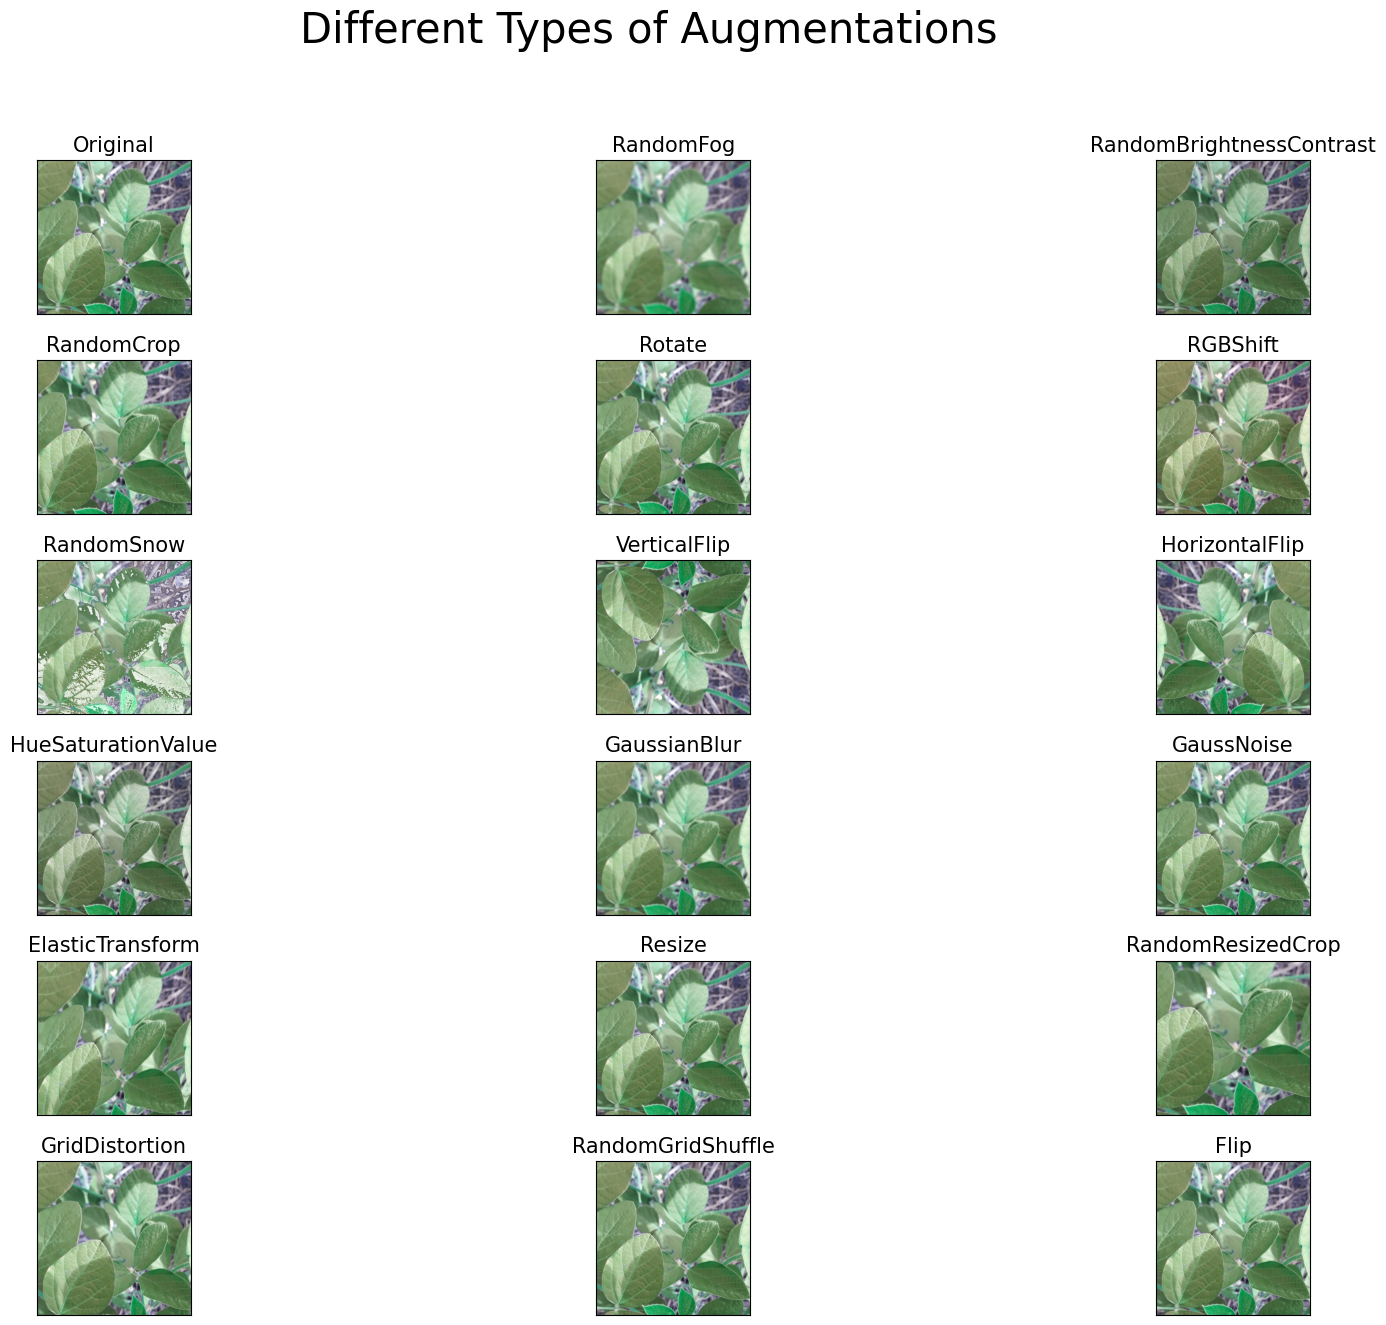

In [16]:
chosen_img = read_img(trial_image)

albumentation_list = [
    A.RandomFog(p=1),
    A.RandomBrightnessContrast(p=1, contrast_limit=0.5),
    A.RandomCrop(p=1, height=448, width=448),
    A.Rotate(p=1, limit=90),
    A.RGBShift(p=1),
    A.RandomSnow(p=1),
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.HueSaturationValue(p=1),
    A.GaussianBlur(p=1),
    A.GaussNoise(p=1),
    A.ElasticTransform(p=1),
    A.Resize(height=512, width=512, p=1),
    A.RandomResizedCrop(height=512, width=512, scale=(0.5, 1.0), p=1),
    A.GridDistortion(p=1),
    A.RandomGridShuffle(),
    A.Flip()
]
    

titles_list = [
    "Original", 
    "RandomFog", 
    "RandomBrightnessContrast", 
    "RandomCrop", 
    "Rotate", 
    "RGBShift", 
    "RandomSnow", 
    "VerticalFlip",
    "HorizontalFlip", 
    "HueSaturationValue", 
    "GaussianBlur", 
    "GaussNoise", 
    "ElasticTransform", 
    "Resize", 
    "RandomResizedCrop",
    "GridDistortion",
    "RandomGridShuffle",
    "Flip"
]

img_matrix_list = [chosen_img]

for aug_type in albumentation_list:
    img = aug_type(image = chosen_img)['image']
    img_matrix_list.append(img)

plot_multiple_img(img_matrix_list, 
                  titles_list, 
                  ncols=3,  # Adjusted ncols to fit all images
                  main_title="Different Types of Augmentations")

/home/agx/agro_sky_ai/AgroSkyAI/agro_venv/lib/python3.8/site-packages/albumentations/core/composition.py:156: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


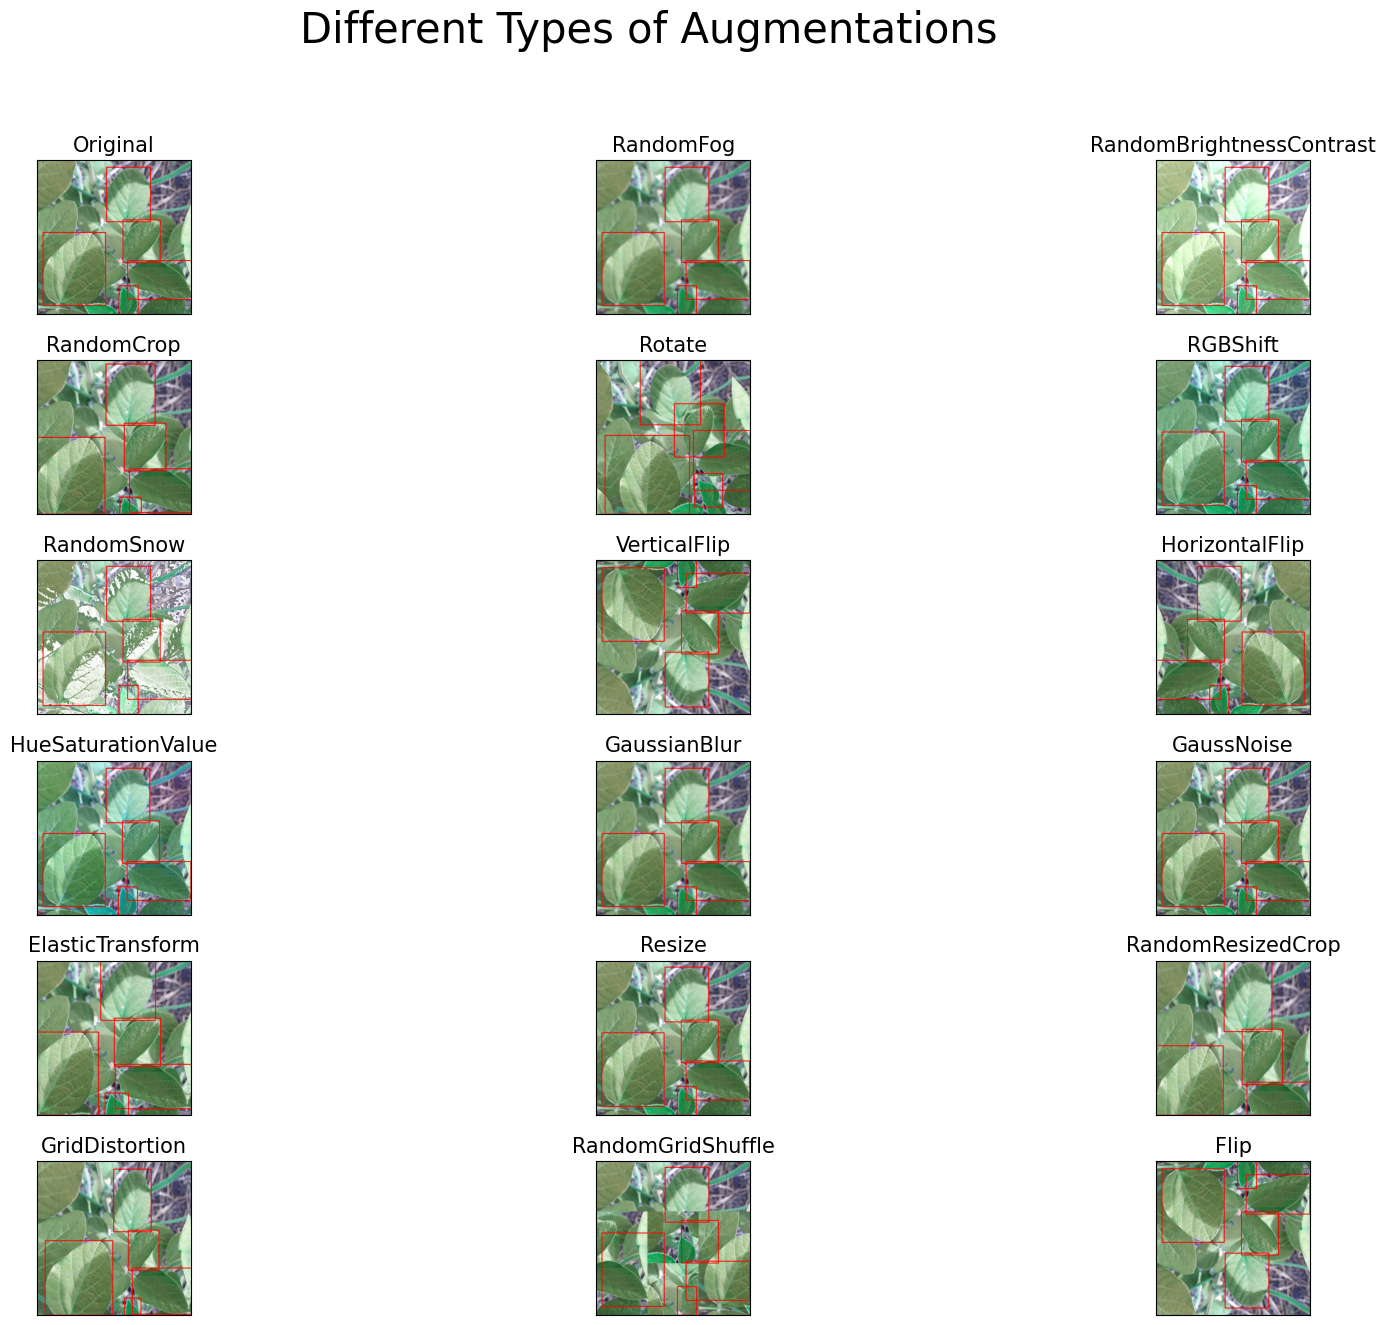

In [17]:
chosen_img = read_img(trial_image)

bboxes = read_bboxes(data_df, trial_image)
bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}

albumentation_list_with_boxes = [
    A.Compose([A.RandomFog(p=1)], bbox_params=bbox_params),
    A.Compose([A.RandomBrightnessContrast(p=1, contrast_limit=0.5)], bbox_params=bbox_params),
    A.Compose([A.RandomCrop(p=1, height=448, width=448)], bbox_params=bbox_params),
    A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params),
    A.Compose([A.RGBShift(p=1)], bbox_params=bbox_params),
    A.Compose([A.RandomSnow(p=1)], bbox_params=bbox_params),
    A.Compose([A.VerticalFlip(p=1)], bbox_params=bbox_params),
    A.Compose([A.HorizontalFlip(p=1)], bbox_params=bbox_params),
    A.Compose([A.HueSaturationValue(p=1)], bbox_params=bbox_params),
    A.Compose([A.GaussianBlur(p=1)], bbox_params=bbox_params),
    A.Compose([A.GaussNoise(p=1)], bbox_params=bbox_params),
    A.Compose([A.ElasticTransform(p=1)], bbox_params=bbox_params),
    A.Compose([A.Resize(height=512, width=512, p=1)], bbox_params=bbox_params),
    A.Compose([A.RandomResizedCrop(height=512, width=512, scale=(0.5, 1.0), p=1)], bbox_params=bbox_params),
    A.Compose([A.GridDistortion(p=1)], bbox_params=bbox_params),
    A.Compose([A.RandomGridShuffle()], bbox_params=bbox_params),
    A.Compose([A.Flip()], bbox_params=bbox_params)
]

titles_list = [
    "Original", 
    "RandomFog", 
    "RandomBrightnessContrast", 
    "RandomCrop", 
    "Rotate", 
    "RGBShift", 
    "RandomSnow", 
    "VerticalFlip",
    "HorizontalFlip", 
    "HueSaturationValue", 
    "GaussianBlur", 
    "GaussNoise", 
    "ElasticTransform", 
    "Resize", 
    "RandomResizedCrop",
    "GridDistortion",
    "RandomGridShuffle",
    "Flip"
]
img_matrix_list_with_boxes = [draw_rect(chosen_img, bboxes)]

for aug_type in albumentation_list_with_boxes:
    # Ensure bboxes are passed correctly to each augmentation
    anno = aug_type(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)))
    img = draw_rect(anno['image'], anno['bboxes'])
    img_matrix_list_with_boxes.append(img)

plot_multiple_img(img_matrix_list_with_boxes, 
                  titles_list, 
                  ncols=3, 
                  main_title="Different Types of Augmentations")

In [52]:
def augment_images(image_list, no_of_aug, image_save_dir, label_save_dir, object_class, file_counter=0):

    bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}
    
    albumentation_list_with_boxes = [
        A.Compose([A.RandomFog(p=1)], bbox_params=bbox_params),
        A.Compose([A.RandomBrightnessContrast(p=1, contrast_limit=0.5)], bbox_params=bbox_params),
        A.Compose([A.RandomCrop(p=1, height=448, width=448)], bbox_params=bbox_params),
        A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params),
        A.Compose([A.RGBShift(p=1)], bbox_params=bbox_params),
        A.Compose([A.RandomSnow(p=1)], bbox_params=bbox_params),
        A.Compose([A.VerticalFlip(p=1)], bbox_params=bbox_params),
        A.Compose([A.HorizontalFlip(p=1)], bbox_params=bbox_params),
        A.Compose([A.HueSaturationValue(p=1)], bbox_params=bbox_params),
        A.Compose([A.GaussianBlur(p=1)], bbox_params=bbox_params),
        A.Compose([A.GaussNoise(p=1)], bbox_params=bbox_params),
        A.Compose([A.ElasticTransform(p=1)], bbox_params=bbox_params),
        A.Compose([A.Resize(height=512, width=512, p=1)], bbox_params=bbox_params),
        A.Compose([A.RandomResizedCrop(height=512, width=512, scale=(0.5, 1.0), p=1)], bbox_params=bbox_params),
        A.Compose([A.GridDistortion(p=1)], bbox_params=bbox_params),
        A.Compose([A.RandomGridShuffle()], bbox_params=bbox_params),
        A.Compose([A.Flip()], bbox_params=bbox_params)
    ]
    
    for img in image_list:
        chosen_img = read_img(img)

        bboxes = read_bboxes(data_df, img)
        
        to_do_augmentations = random.sample(albumentation_list_with_boxes, no_of_aug)
        
        for aug_type in to_do_augmentations:
            # Handle cropping augmentation
            try:
                anno = aug_type(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)) * object_class)
            except:
                replacement_list = [0, 1] + list(range(3, 17))
                aug = albumentation_list_with_boxes[random.sample(replacement_list, 1)[0]]
                anno = aug(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)) * object_class)
                
            aug_img = anno['image']
            aug_bboxes = anno['bboxes']

            img_name = f"aug_image_{file_counter}.png"
            label_name = f"aug_image_{file_counter}.csv"
            # Save the augmented image
            image_save_path = image_save_dir / img_name
            cv2.imwrite(str(image_save_path), aug_img)

            # Convert bboxes to COCO format string
            coco_bboxes = utils.convert_bbox(aug_bboxes, "pascal_voc", "coco", (None, None))

            label_save_path = label_save_dir / label_name
            
            with open(label_save_path, 'w') as f:
                f.write(str(img_name)+",")
                f.write(str(object_class) + ",")
                for index, bbox in enumerate(coco_bboxes):
                    for j in range(len(bbox)):
                        if j == 3 and index != len(coco_bboxes) - 1:
                            f.write(str(bbox[j]) + ";")
                        else:
                            f.write(str(bbox[j]) + " ")
                f.write("\n")
            
            file_counter += 1

    return file_counter

In [38]:
augmented_images_counter = 0

In [41]:
# augment 106 soy images with 18 augmentations each
soy_image_list = [f"image_{i}.png" for i in range(106)]
augmented_images_counter = augment_images(soy_image_list, 17, base_dir/"augmented_images", base_dir/"augmented_labels", object_class=1, file_counter=augmented_images_counter)
print(augmented_images_counter)

/home/agx/agro_sky_ai/AgroSkyAI/agro_venv/lib/python3.8/site-packages/albumentations/core/composition.py:156: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


1802


In [54]:
augmented_images_counter = 1802

In [55]:
# augment 250 sunflower images with 7 augmentations each
selected_sunflower_integers = random.sample(range(106, 421), 250)
sunflower_image_list = [f"image_{i}.png" for i in selected_sunflower_integers]
augmented_images_counter = augment_images(sunflower_image_list, 7, base_dir/"augmented_images", base_dir/"augmented_labels", object_class=2, file_counter=augmented_images_counter)
print(augmented_images_counter)

/home/agx/agro_sky_ai/AgroSkyAI/agro_venv/lib/python3.8/site-packages/albumentations/core/composition.py:156: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


3552


In [58]:
augmented_images_counter = 3552

In [56]:
# augment 500 wheat images with 2 augmentations each
selected_wheat_integers = random.sample(range(421, 1421), 500)
wheat_image_list = [f"image_{i}.png" for i in selected_wheat_integers]
augmented_images_counter = augment_images(wheat_image_list, 2, base_dir/"augmented_images", base_dir/"augmented_labels", object_class=3, file_counter=augmented_images_counter)
print(augmented_images_counter)

/home/agx/agro_sky_ai/AgroSkyAI/agro_venv/lib/python3.8/site-packages/albumentations/core/composition.py:156: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


4552


In [59]:
augmented_images_counter = 4552

In [7]:
augmented_directory_path = base_dir/"augmented_labels"
augmented_data_df = load_data_from_directory(augmented_directory_path)
print(augmented_data_df.head())

DataFrame size:  (52711, 6)
           image_name  class   x_min   y_min   x_max   y_max
0   aug_image_777.png      1     1.0   581.0  2010.0  2136.0
1   aug_image_777.png      1   225.0  2121.0  2175.0  4391.0
2   aug_image_777.png      1  1925.0  1301.0  3445.0  3131.0
3   aug_image_777.png      1  1590.0  3366.0  3095.0  4551.0
4  aug_image_4043.png      3    36.0    10.0   116.0    90.0


In [64]:
augmented_data_df['image_name'].nunique()

4552

In [8]:
final_df = pd.concat([data_df, augmented_data_df], ignore_index=True)

In [9]:
final_df['class'] = final_df['class'] - 1

In [66]:
# for _ in range(5):
#     final_df = final_df.sample(frac=1, random_state=my_seed).reset_index(drop=True)

In [10]:
print(final_df.head())

       image_name  class  x_min  y_min   x_max  y_max
0   image_410.png      1  130.0   22.0   583.0  493.0
1  image_1143.png      2  517.0  366.0   679.0  462.0
2  image_1143.png      2  518.0    0.0   614.0  233.0
3  image_1143.png      2  943.0  423.0  1023.0  503.0
4  image_1143.png      2  720.0    1.0   820.0   82.0


In [11]:
grouped_df = final_df.groupby('image_name').first().reset_index()

In [12]:
def copy_files_and_save_labels(df, subset_dir):
    for _, row in df.iterrows():
        img_name = row['image_name']
        img_path = os.path.join(base_dir, "images" if img_name[:3] != "aug" else "augmented_images", img_name)
        
        # Copy the image
        # shutil.copy(img_path, os.path.join(subset_dir, 'images', img_name))
        
        # Handle bounding boxes
        bboxes = read_bboxes(df, img_name)  # Assuming this function handles NaN values internally
        if bboxes is None or not bboxes.size or pd.isnull(bboxes).all():
            continue  # Skip generating a label file for this image if there are NaN values
        
        img = read_img(img_path, True)
        img_h, img_w = img.shape[:2]

        # Verify and filter Pascal VOC bounding boxes
        valid_pascal_voc_bboxes = []
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            if 0 <= x_min < x_max <= img_w and 0 <= y_min < y_max <= img_h:
                valid_pascal_voc_bboxes.append(bbox)
            else:
                print(f"Invalid Pascal VOC bbox {bbox} for image {img_name}, skipping this bbox.")

        # Skip the image if no valid Pascal VOC bounding boxes are found
        if not valid_pascal_voc_bboxes:
            continue
        
        # Convert to YOLO format
        yolo_bboxes = convert_bbox(valid_pascal_voc_bboxes, "pascal_voc", "yolo", (img_w, img_h))

        # Verify and filter YOLO bounding boxes
        valid_yolo_bboxes = []
        for bbox in yolo_bboxes:
            x_center, y_center, width, height = bbox
            if all(0 <= coord <= 1 for coord in bbox):
                valid_yolo_bboxes.append(bbox)
            else:
                print(f"Invalid YOLO bbox {bbox} for image {img_name}, skipping this bbox.")

        # Skip the image if no valid YOLO bounding boxes are found
        if not valid_yolo_bboxes:
            continue
        
        # Save the labels in YOLO format
        with open(os.path.join(subset_dir, 'labels', os.path.splitext(img_name)[0] + '.txt'), 'w') as f:
            for bbox in valid_yolo_bboxes:
                f.write(f"{row['class']} " + " ".join(map(str, bbox)) + "\n")


for i in range(3):
    # Initial split to create train (70%) and remaining (30%) sets
    train_images, remaining_images = train_test_split(grouped_df['image_name'], test_size=0.30, stratify=grouped_df['class'], random_state=my_seed+i)
    
    # Split the remaining set into validation (15%) and test (15%)
    val_images, test_images = train_test_split(remaining_images, test_size=0.50, stratify=grouped_df.loc[grouped_df['image_name'].isin(remaining_images), 'class'],
                                               random_state=my_seed+i)
    
    # Get dataframes for each set
    train_df = final_df[final_df['image_name'].isin(train_images)]
    val_df = final_df[final_df['image_name'].isin(val_images)]
    test_df = final_df[final_df['image_name'].isin(test_images)]

    
    fold_dir = os.path.join(base_dir, f'fold{i+1}')
    os.makedirs(fold_dir, exist_ok=True)
    
    # Create subdirectories for train, val, and test
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')
    test_dir = os.path.join(fold_dir, 'test')

    for subdir in [train_dir, val_dir, test_dir]:
        os.makedirs(subdir, exist_ok=True)
        os.makedirs(os.path.join(subdir, 'images'), exist_ok=True)
        os.makedirs(os.path.join(subdir, 'labels'), exist_ok=True)

    print(f"Fold{i} starting")
    if i > 0:
        copy_files_and_save_labels(train_df, train_dir)
        print("training set done")
        copy_files_and_save_labels(val_df, val_dir)
        print("val set done")
    copy_files_and_save_labels(test_df, test_dir)
    print("test set done")
    print(f"Fold{i} done")

Fold0 starting
test set done
Fold0 done
Fold1 starting
training set done
val set done
test set done
Fold1 done
Fold2 starting
training set done
val set done
test set done
Fold2 done


In [97]:
# def mosaic(all_img_list, all_annos, idxs, output_size, scale_range, filter_scale=0.):
#     output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
#     scale_x = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
#     scale_y = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
#     divid_point_x = int(scale_x * output_size[1])
#     divid_point_y = int(scale_y * output_size[0])

#     new_anno = []
#     for i, idx in enumerate(idxs):
#         path = all_img_list[idx]
#         img_annos = all_annos[idx]

#         img = cv2.imread(path)
#         if i == 0:  # top-left
#             img = cv2.resize(img, (divid_point_x, divid_point_y))
#             output_img[:divid_point_y, :divid_point_x, :] = img
#             for bbox in img_annos:
                
#                 # As YOLO annotations have different centers from the image, this is how the bbox coordinates are calculated
#                 xmin = bbox[1] - bbox[3]*0.5
#                 ymin = bbox[2] - bbox[4]*0.5
#                 xmax = bbox[1] + bbox[3]*0.5
#                 ymax = bbox[2] + bbox[4]*0.5

#                 xmin *= scale_x
#                 ymin *= scale_y
#                 xmax *= scale_x
#                 ymax *= scale_y
#                 new_anno.append([bbox[0], xmin, ymin, xmax, ymax])

#         elif i == 1:  # top-right
#             img = cv2.resize(img, (output_size[1] - divid_point_x, divid_point_y))
#             output_img[:divid_point_y, divid_point_x:output_size[1], :] = img
#             for bbox in img_annos:
#                 xmin = bbox[1] - bbox[3]*0.5
#                 ymin = bbox[2] - bbox[4]*0.5
#                 xmax = bbox[1] + bbox[3]*0.5
#                 ymax = bbox[2] + bbox[4]*0.5

#                 xmin = scale_x + xmin * (1 - scale_x)
#                 ymin = ymin * scale_y
#                 xmax = scale_x + xmax * (1 - scale_x)
#                 ymax = ymax * scale_y
#                 new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
#         elif i == 2:  # bottom-left
#             img = cv2.resize(img, (divid_point_x, output_size[0] - divid_point_y))
#             output_img[divid_point_y:output_size[0], :divid_point_x, :] = img
#             for bbox in img_annos:
#                 xmin = bbox[1] - bbox[3]*0.5
#                 ymin = bbox[2] - bbox[4]*0.5
#                 xmax = bbox[1] + bbox[3]*0.5
#                 ymax = bbox[2] + bbox[4]*0.5

#                 xmin = xmin * scale_x
#                 ymin = scale_y + ymin * (1 - scale_y)
#                 xmax = xmax * scale_x
#                 ymax = scale_y + ymax * (1 - scale_y)
#                 new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
#         else:  # bottom-right
#             img = cv2.resize(img, (output_size[1] - divid_point_x, output_size[0] - divid_point_y))
#             output_img[divid_point_y:output_size[0], divid_point_x:output_size[1], :] = img
#             for bbox in img_annos:
#                 xmin = bbox[1] - bbox[3]*0.5
#                 ymin = bbox[2] - bbox[4]*0.5
#                 xmax = bbox[1] + bbox[3]*0.5
#                 ymax = bbox[2] + bbox[4]*0.5

#                 xmin = scale_x + xmin * (1 - scale_x)
#                 ymin = scale_y + ymin * (1 - scale_y)
#                 xmax = scale_x + xmax * (1 - scale_x)
#                 ymax = scale_y + ymax * (1 - scale_y)
#                 new_anno.append([bbox[0], xmin, ymin, xmax, ymax])

#     if 0 < filter_scale:
#         new_anno = [anno for anno in new_anno if
#                     filter_scale < (anno[3] - anno[1]) and filter_scale < (anno[4] - anno[2])]

#     return output_img, new_anno

In [98]:
# OUTPUT_SIZE = (448, 448)  # Height, Width
# SCALE_RANGE = (0.3, 0.7)
# FILTER_TINY_SCALE = 1 / 50  # if height or width lower than this scale, drop it.

# img_names = ["image_500.png", "image_0.png", "image_900.png", "image_50.png"]
# img_paths = [get_image_path(name) for name in img_names]
# annos = [read_bboxes(data_df, "image_500.png"), read_bboxes(data_df, "image_0.png"), read_bboxes(data_df, "image_900.png"), read_bboxes(data_df, "image_50.png")]

# images = [read_img(image_name) for image_name in img_names]
# annos = [utils.convert_bbox(bboxes, "coco", "yolo", (images[i].shape[0], images[i].shape[1])) for i, bboxes in enumerate(annos)]

# [bbox.insert(0, 0) for bboxes in annos for bbox in bboxes]
# stuff = annos[0][0].insert(0, 0)


# idxs = random.sample(range(len(annos)), 4)

# new_image, new_annos = mosaic(img_paths, annos,
#                               idxs,
#                               OUTPUT_SIZE, SCALE_RANGE,
#                               filter_scale=FILTER_TINY_SCALE)

# cv2.imwrite('output.jpg', new_image) #The mosaic image
# for anno in new_annos:
#     start_point = (int(anno[1] * OUTPUT_SIZE[1]), int(anno[2] * OUTPUT_SIZE[0]))
#     end_point = (int(anno[3] * OUTPUT_SIZE[1]), int(anno[4] * OUTPUT_SIZE[0]))
#     cv2.rectangle(new_image, start_point, end_point, (0, 255, 0), 1, cv2.LINE_AA)
# cv2.imwrite('output_box.jpg', new_image) # The mosaic image with the bounding boxes

# yolo_anno = []

# for anno in annos:
#     print(anno)
#     tmp = []
#     tmp.append(anno[0])
#     tmp.append((anno[3]+anno[1])/2)
#     tmp.append((anno[4]+anno[2])/2)
#     tmp.append(anno[3]-anno[1])
#     tmp.append(anno[4]-anno[2])
#     yolo_anno.append(tmp)
#     print("Adwadw")
# with open('output.txt', 'w') as file: # The output annotation file will appear in the output.txt file
#   for line in yolo_anno:
#     file.write((' ').join([str(x) for x in line]) + '\n') 